In [1]:
# =========================
# Colab Cell 1 — Install + Imports
# =========================
!pip -q install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

In [2]:
# =========================
# Colab Cell 2 — Download series from FRED (no API key)
# Uses: https://fred.stlouisfed.org/graph/fredgraph.csv?id=SERIES_ID
# =========================
def fred_series(series_id: str) -> pd.DataFrame:
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = pd.read_csv(url)
    df.columns = ["date", series_id]
    df["date"] = pd.to_datetime(df["date"])
    df[series_id] = pd.to_numeric(df[series_id], errors="coerce")
    return df.set_index("date")

series_ids = [
    "DGS10",     # 10Y Treasury yield
    "DGS2",      # 2Y Treasury yield
    "DGS3MO",    # 3M Treasury yield
    "UNRATE",    # unemployment rate
    "CPIAUCSL",  # CPI
    "INDPRO",    # industrial production index
    "USREC"      # NBER recession indicator (0/1)
]

raw = None
for sid in series_ids:
    df = fred_series(sid)
    raw = df if raw is None else raw.join(df, how="outer")

raw.tail()

,DGS10,DGS2,DGS3MO,UNRATE,CPIAUCSL,INDPRO,USREC
date,,,,,,,
2026-02-19,4.08,3.47,3.69,NaN,NaN,NaN,NaN
2026-02-20,4.08,3.48,3.69,NaN,NaN,NaN,NaN
2026-02-23,4.03,3.43,3.69,NaN,NaN,NaN,NaN
2026-02-24,4.04,3.43,3.69,NaN,NaN,NaN,NaN
2026-02-25,4.05,3.45,3.69,NaN,NaN,NaN,NaN


In [3]:
# =========================
# Colab Cell 3 — Make everything monthly + feature engineering
# - Yields are daily; resample to monthly mean
# - Macro series are monthly already; resampling is safe
# =========================
monthly = raw.resample("M").mean()

# Basic features
monthly["spread_10y_2y"] = monthly["DGS10"] - monthly["DGS2"]
monthly["spread_10y_3m"] = monthly["DGS10"] - monthly["DGS3MO"]

# Inflation proxy: YoY % change in CPI
monthly["cpi_yoy_pct"] = monthly["CPIAUCSL"].pct_change(12) * 100

# Industrial production YoY % change
monthly["indpro_yoy_pct"] = monthly["INDPRO"].pct_change(12) * 100

# Unemployment change (3-month delta)
monthly["unrate_chg_3m"] = monthly["UNRATE"] - monthly["UNRATE"].shift(3)

# Smooth some noisy features (optional, keeps it simple but robust)
for col in ["spread_10y_2y", "spread_10y_3m", "cpi_yoy_pct", "indpro_yoy_pct", "unrate_chg_3m"]:
    monthly[f"{col}_ma3"] = monthly[col].rolling(3).mean()

monthly.tail(15)

/tmp/ipython-input-844/2715728383.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = raw.resample("M").mean()
/tmp/ipython-input-844/2715728383.py:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly["cpi_yoy_pct"] = monthly["CPIAUCSL"].pct_change(12) * 100
/tmp/ipython-input-844/2715728383.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly["indpro_yoy_pct"] = monthly["INDPRO"].pct_change(12) * 100


,DGS10,DGS2,DGS3MO,UNRATE,CPIAUCSL,INDPRO,USREC,spread_10y_2y,spread_10y_3m,cpi_yoy_pct,indpro_yoy_pct,unrate_chg_3m,spread_10y_2y_ma3,spread_10y_3m_ma3,cpi_yoy_pct_ma3,indpro_yoy_pct_ma3,unrate_chg_3m_ma3
date,,,,,,,,,,,,,,,,,
2024-12-31,4.391429,4.225714,4.390952,4.1,317.604,100.3273,0.0,0.165714,0.000476,2.870691,-0.274147,0.0,0.129106,-0.295487,2.723002,-0.942274,-3.333333e-02
2025-01-31,4.629048,4.271905,4.342857,4.0,318.961,100.0647,0.0,0.357143,0.286190,2.990978,0.849003,-0.1,0.207093,0.007485,2.860381,-0.327695,-3.333333e-02
2025-02-28,4.451053,4.210000,4.332105,4.2,319.679,101.0993,0.0,0.241053,0.118947,2.801583,0.811986,0.0,0.254637,0.135205,2.887751,0.462281,-3.333333e-02
2025-03-31,4.280476,3.970000,4.335714,4.2,319.785,101.0404,0.0,0.310476,-0.055238,2.381981,0.580245,0.1,0.302891,0.116633,2.724848,0.747078,2.960595e-16
2025-04-30,4.279048,3.777619,4.322381,4.2,320.302,101.1279,0.0,0.501429,-0.043333,2.325388,0.882352,0.2,0.350986,0.006792,2.502984,0.758195,1.000000e-01
2025-05-31,4.423810,3.920000,4.361429,4.3,320.620,100.9655,0.0,0.503810,0.062381,2.377265,0.101623,0.1,0.438571,-0.012063,2.361545,0.521407,1.333333e-01
2025-06-30,4.383500,3.889000,4.421000,4.1,321.435,101.4785,0.0,0.494500,-0.037500,2.680454,0.579321,-0.1,0.499913,-0.006151,2.461036,0.521099,6.666667e-02
2025-07-31,4.391818,3.882273,4.412273,4.3,322.169,101.8940,0.0,0.509545,-0.020455,2.742618,1.918766,0.1,0.502618,0.001475,2.600112,0.866570,3.333333e-02
2025-08-31,4.264762,3.703810,4.304762,4.3,323.291,101.6247,0.0,0.560952,-0.040000,2.938592,1.188678,0.0,0.521666,-0.032652,2.787221,1.228922,-2.960595e-16


In [4]:
# =========================
# Colab Cell 4 — Create the label (recession within next 6 months)
# y = 1 if USREC hits 1 anytime in the next 6 months (including current month)
# This creates a forward-looking classification target.
# =========================
horizon_months = 6

# USREC is 1 during recessions, 0 otherwise
future_max = monthly["USREC"].shift(-0).rolling(window=horizon_months, min_periods=1).max().shift(-(horizon_months-1))
monthly["recession_next_6m"] = (future_max >= 1).astype(int)

# Drop rows with missing essentials
feature_cols = [
    "spread_10y_2y_ma3",
    "spread_10y_3m_ma3",
    "cpi_yoy_pct_ma3",
    "indpro_yoy_pct_ma3",
    "unrate_chg_3m_ma3",
    "UNRATE"
]

dataset = monthly[feature_cols + ["recession_next_6m"]].dropna().copy()
dataset.tail()

,spread_10y_2y_ma3,spread_10y_3m_ma3,cpi_yoy_pct_ma3,indpro_yoy_pct_ma3,unrate_chg_3m_ma3,UNRATE,recession_next_6m
date,,,,,,,
2025-05-31,0.438571,-0.012063,2.361545,0.521407,1.333333e-01,4.3,0
2025-06-30,0.499913,-0.006151,2.461036,0.521099,6.666667e-02,4.1,0
2025-07-31,0.502618,0.001475,2.600112,0.866570,3.333333e-02,4.3,0
2025-08-31,0.521666,-0.032652,2.787221,1.228922,-2.960595e-16,4.3,0
2025-09-30,0.540801,-0.001898,2.901260,1.669529,1.333333e-01,4.4,0


In [5]:
# =========================
# Colab Cell 5 — Save the dataset (this is the CSV you upload to GitHub)
# =========================
csv_path = "/content/recession_ml_dataset.csv"
dataset.to_csv(csv_path, index=True)
csv_path, dataset.shape

('/content/recession_ml_dataset.csv', (527, 7))

In [6]:
# =========================
# Colab Cell 6 — Train/Test split (time-based) + Model training
# =========================
X = dataset[feature_cols].values
y = dataset["recession_next_6m"].values
dates = dataset.index

split_date = pd.Timestamp("2008-01-31")  # you can change this
train_mask = dates < split_date
test_mask = ~train_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

# 1) Logistic Regression (interpretable baseline)
lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)[:, 1]

# 2) Random Forest (non-linear, still simple)
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    min_samples_leaf=3
)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:, 1]

print("LogReg ROC-AUC:", roc_auc_score(y_test, lr_proba))
print("RandForest ROC-AUC:", roc_auc_score(y_test, rf_proba))

LogReg ROC-AUC: 0.8387234042553191
RandForest ROC-AUC: 0.7872340425531914


<Figure size 640x480 with 0 Axes>

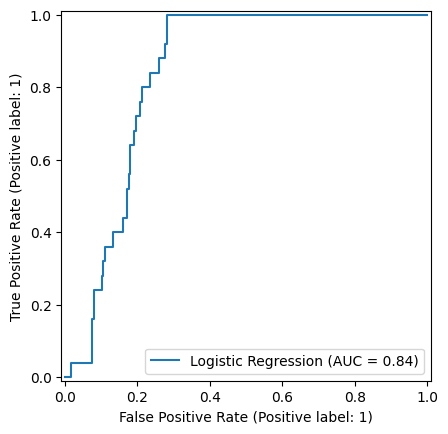

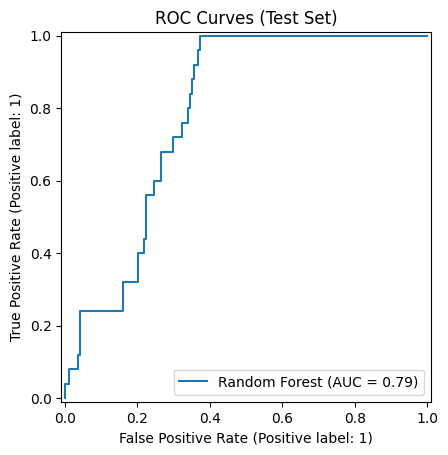

Confusion Matrix:
 [[155  33]
 [ 17   8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       188
           1       0.20      0.32      0.24        25

    accuracy                           0.77       213
   macro avg       0.55      0.57      0.55       213
weighted avg       0.82      0.77      0.79       213



In [7]:
# =========================
# Colab Cell 7 — Evaluation + Plots
# =========================
fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, lr_proba, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, rf_proba, name="Random Forest")
plt.title("ROC Curves (Test Set)")
plt.show()

# Pick one model to inspect classification report
best_proba = rf_proba  # change to lr_proba if you prefer
y_pred = (best_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Latest month in dataset: 2025-09-30
Recession risk (next 6m) - Logistic Regression: 71.87%
Recession risk (next 6m) - Random Forest:      69.66%


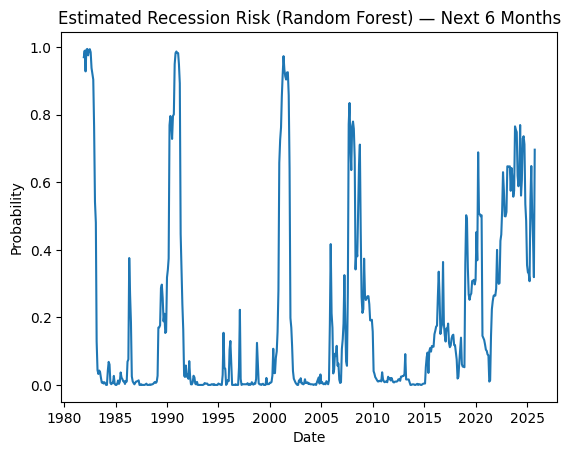

In [8]:
# =========================
# Colab Cell 8 — "Current risk" output + simple chart
# =========================
latest_row = dataset.iloc[-1]
latest_date = dataset.index[-1]

latest_X = latest_row[feature_cols].values.reshape(1, -1)
latest_risk_lr = lr.predict_proba(latest_X)[0, 1]
latest_risk_rf = rf.predict_proba(latest_X)[0, 1]

print(f"Latest month in dataset: {latest_date.date()}")
print(f"Recession risk (next 6m) - Logistic Regression: {latest_risk_lr:.2%}")
print(f"Recession risk (next 6m) - Random Forest:      {latest_risk_rf:.2%}")

# Plot risk over time (RF)
risk_series = pd.Series(rf.predict_proba(dataset[feature_cols].values)[:, 1], index=dataset.index)

plt.figure()
plt.plot(risk_series.index, risk_series.values)
plt.title("Estimated Recession Risk (Random Forest) — Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.show()

In [9]:
# =========================
# Colab Cell 9 — Download the dataset to your machine
# =========================
from google.colab import files
files.download("/content/recession_ml_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>